In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

import os
os.chdir("..") # go to root dir

# Read Data

In [2]:
rating = pd.read_csv('data/interim/rating.csv')
users = pd.read_csv('data/interim/users.csv')
items = pd.read_csv('data/interim/items.csv')

In [3]:
rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Define Model

Model architecture:
- pass `user_id` throught embedding
- pass `item_id` throught embedding
- give some additional information about the item to the model

In [4]:
class HybridModel(nn.Module):
    """HybribModel
        - take user_id, item_id and some item_features
        - returns predicted rating
    
    """
    
    def __init__(self, num_users, num_items, embed_dim, items_features, hidden_dim, dropout=0.1):
        super(HybridModel, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        
        self.fc_out = nn.Sequential(
            nn.Linear(2 * embed_dim + items_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, 1),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, user_id, item_id, item_feat):
        user_embed = self.dropout(self.user_embedding(user_id))
        item_embed = self.dropout(self.item_embedding(item_id))
        
        x = torch.cat((user_embed, item_embed, item_feat), dim=1)
        
        x = self.fc_out(x)
        
        return x

In [5]:
# split dataset into train and test set
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(rating.index, test_size=0.2)

/home/sadi/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model training

In [6]:
# let's merge rating and items table
rating = rating.merge(items, on='item_id')
rating

,user_id,item_id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962),01-Jan-1962,http://us.imdb.com/M/title-exact?Mamma%20Roma%...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,655,1640,3,888474646,"Eighth Day, The (1996)",01-Nov-1996,"http://us.imdb.com/Title?Huiti%E8me+jour,+Le+(...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,655,1637,3,888984255,Girls Town (1996),23-Aug-1996,http://us.imdb.com/M/title-exact?Girls%20Town%...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1...",02-Feb-1996,http://us.imdb.com/M/title-exact?Saimt%20el%20...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def collate_batch(batch):
    users_id = []
    items_id = []
    items_feat = []
    ratings = []
    for i in batch:
        users_id.append(rating['user_id'][i])
        items_id.append(rating['item_id'][i])
        ratings.append(rating['rating'][i])
        
        # get movie features
        items_feat.append(
            torch.tensor(rating.iloc[i, 7:].to_numpy(dtype=np.int64))
        )
    users_id = torch.tensor(users_id)
    items_id = torch.tensor(items_id)
    items_feat = torch.stack(items_feat, dim=0)
    ratings = torch.tensor(ratings).reshape(-1, 1).float()
    
    return users_id, items_id, items_feat, ratings

train_dataloader = DataLoader(
    train_idx,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_batch,
)

val_dataloader = DataLoader(
    val_idx,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_batch,
)

In [8]:
for users_id, items_id, items_feat, ratings in train_dataloader:
    print("users_id:", users_id.shape)
    print("items_id:", items_id.shape)
    print("items_feat:", items_feat.shape)
    print("ratings:", ratings.shape)
    break

users_id: torch.Size([32])
items_id: torch.Size([32])
items_feat: torch.Size([32, 19])
ratings: torch.Size([32, 1])


## Train Model

In [9]:
def train_epoch(model, train_loader, optimizer, loss_fn, device, epoch=None):
    loop = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f'Training {epoch}',
    )
    
    cur_loss = 0
    model.train()
    for i, (user_id, item_id, item_feat, rating) in loop:
        user_id = user_id.to(device)
        item_id = item_id.to(device)
        item_feat = item_feat.to(device)
        rating = rating.to(device)
        
        rating_pred = model(user_id, item_id, item_feat)
        loss = loss_fn(rating_pred, rating)
        
        # backward and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.item()
        loop.set_postfix(**{"loss": cur_loss / (i + 1)})
    
    return cur_loss / len(train_loader)


def eval_epoch(model, val_loader, loss_fn, device, epoch=None):
    loop = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f'Evaluating {epoch}',
    )
    
    cur_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (user_id, item_id, item_feat, rating) in loop:
            user_id = user_id.to(device)
            item_id = item_id.to(device)
            item_feat = item_feat.to(device)
            rating = rating.to(device)
            
            rating_pred = model(user_id, item_id, item_feat)
            loss = loss_fn(rating_pred, rating)
            
            cur_loss += loss.item()
            loop.set_postfix(**{"loss": cur_loss / (i + 1)})
    
    return cur_loss / len(val_loader)


def train(model, loaders, optimizer, loss_fn, epochs, device):
    train_loss = []
    val_loss = []
    for epoch in range(1, epochs+1):
        train_loss.append(train_epoch(model, loaders[0], optimizer, loss_fn, device, epoch))
        
        if len(loaders) > 1:
            val_loss.append(eval_epoch(model, loaders[1], loss_fn, device, epoch))
            
    return train_loss, val_loss

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_users = len(users)+1
num_items = len(items)+1
embed_dim = 64
items_features = 19 # number genres
hidden_dim = 64
dropout = 0.3

/home/sadi/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
model = HybridModel(num_users, num_items, embed_dim, items_features, hidden_dim, dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [12]:
# train the model
epochs = 15

train_loss, val_loss = train(
    model, 
    loaders=(train_dataloader, val_dataloader),
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device,
)

Training 1:   0%|          | 1/2500 [00:00<07:12,  5.78it/s, loss=10.9]

Evaluating 15: 100%|██████████| 625/625 [00:13<00:00, 46.58it/s, loss=0.888]


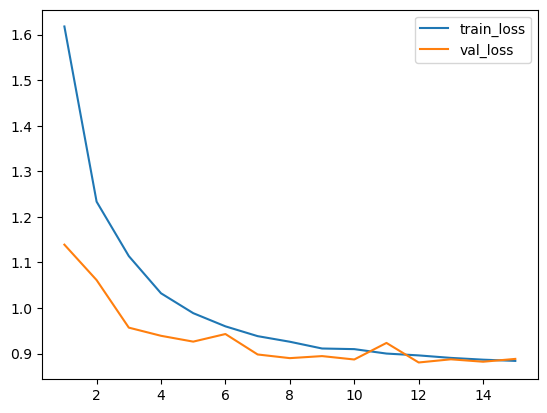

In [19]:
plt.plot(range(1, len(train_loss)+1), train_loss, label='train_loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='val_loss')
plt.legend()
plt.show()

## Predict some movies for user 1

In [13]:
from benchmark.evaluate import predict_movie

user_id = 1

already_watched = rating[rating['user_id'] == user_id]['item_id'].unique()

already_watched_name = rating[rating['user_id'] == user_id]
already_watched_name = [
    (already_watched_name['rating'][i], already_watched_name['movie_title'][i])
    for i in already_watched_name.index
]
already_watched_name = sorted(already_watched_name, key=lambda x: x[0], reverse=True)

print("Already watched movies (top 10):", *[name for rating, name in already_watched_name[:10]], sep='\n')
print('='*50, end='\n\n')
predicted_movies = predict_movie(model, user_id, already_watched, items, top_k=10)

print(f"Predicted movies for user {user_id} (top 10):", *predicted_movies, sep='\n')

Already watched movies (top 10):
Kolya (1996)
Remains of the Day, The (1993)
Toy Story (1995)
Chasing Amy (1997)
Crumb (1994)
French Twist (Gazon maudit) (1995)
Fargo (1996)
Return of the Jedi (1983)
Dead Poets Society (1989)
Mr. Holland's Opus (1995)

Predicted movies for user 1 (top 10):
Casablanca (1942)
Close Shave, A (1995)
Schindler's List (1993)
Pather Panchali (1955)
To Kill a Mockingbird (1962)
One Flew Over the Cuckoo's Nest (1975)
Manchurian Candidate, The (1962)
Prefontaine (1997)
Sunset Blvd. (1950)
North by Northwest (1959)


## Save Model

In [14]:
torch.save(model, 'models/recsys_model.pt')

## Save val dataset

In [15]:
# create val dataset
# rating.iloc[val_idx].to_csv('benchmark/data/val_dataset.csv', index=False)

# also record already watched movies by users, save in already_watched.csv, rows: user_id, already_watched(list)
already_watched = []
df = rating.iloc[train_idx]
for user_id in users['user_id'].to_list():
    aw = list(df[df['user_id'] == user_id]['item_id'].unique())
    
    # convert aw to str to save it
    aw = [str(x) for x in aw]
    aw = ' '.join(aw)
    
    already_watched.append({
        'user_id': user_id,
        'already_watched': aw,
    })

already_watched = pd.DataFrame(already_watched)

already_watched.to_csv('benchmark/data/already_watched.csv', index=False)
already_watched

,user_id,already_watched
0,1,179 146 48 76 226 176 213 268 20 11 250 26 261...
1,2,298 275 312 286 303 127 284 292 295 50 277 313...
2,3,318 302 339 333 307 323 181 335 268 353 340 33...
3,4,327 359 294 328 362 50 288 260 301 329 264 357...
4,5,398 426 399 433 154 374 259 204 367 401 144 80...
...,...,...
938,939,1054 546 118 255 591 1277 127 405 252 258 1190...
939,940,82 751 746 7 301 161 56 549 89 213 316 171 183...
940,941,993 147 358 258 124 300 408 294 7 257 919 763 ...
941,942,313 124 328 750 500 528 97 135 193 79 316 478 ...


# Evaluate

In [16]:
from benchmark.evaluate import evaluate

val_dataset = pd.read_csv('benchmark/data/val_dataset.csv')
already_watched = pd.read_csv('benchmark/data/already_watched.csv')
movies = pd.read_csv('data/interim/items.csv')

loss, accuracy = evaluate(model, val_dataset, already_watched, movies)

Calculating Metrics: 100%|██████████| 20000/20000 [00:39<00:00, 506.66it/s]


In [17]:
print("loss:", loss)
print("accuracy:", accuracy)

loss: 0.8272227096129285
accuracy: 0.85955
